# Курсовая работа по предмету "Машинное обучение и анализ данных", вариант 9
Выполнил Малышев Андрей, ШАД-211

Условие: VPLDAGNR in [0,1,2]

In [94]:
# базовая работа с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# алгоритмы МО
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# AutoML
import h2o
from h2o.automl import H2OAutoML

In [95]:
# 1. Загрузка и фильтрация данных по условию
df = pd.read_csv('Dataset_2_DATA.csv')
df = df[df['VPLDAGNR'].isin([0, 1, 2])].reset_index(drop=True)
print(f"Размер датасета после фильтрации: {df.shape}")

# Удаление пустых столбцов или столбцов с константами
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
df.drop(columns=const_cols, inplace=True)
print("Удалены столбцы:", const_cols)

# Проверка пропусков
print("Пропущено значений в столбце:\n", df.isna().sum())

Размер датасета после фильтрации: (4902, 56)
Удалены столбцы: ['HH_VALID', 'P_VALID', 'WEGGEWEEST']
Пропущено значений в столбце:
 HHID                       0
PERSID                     0
VPLID                      0
RitID                      0
KHVM                       0
VERTREKP                   0
AANTVPL                    0
VPLDAGNR                   0
VERPL                      0
VERPLNR                    0
TOER                       0
TOER_TYPE                  0
AANTRIT                    0
KMOTIEF                    0
VERTPROV                   0
AANKPROV                   0
KAFSTV                     0
KVERTTIJD                  0
KREISDUUR                  0
ROLAUTO                    0
PARKEERKOSTEN              0
VERTRAGING                 0
DAGSOORT                   0
OORDEEL_AUTO               0
OORDEEL_TREIN              0
OORDEEL_BTM                0
OORDEEL_FIETS              0
OORDEEL_BROMMER            0
OORDEEL_LOPEN              0
GEBRUIK_AUTO_STELLING3     0

0 напротив каждого названия столбца означает, что в столбце 0 пропущенных значений.

Строки с пропущенными значениями в столбцах были удалены из датасета для обучения модели

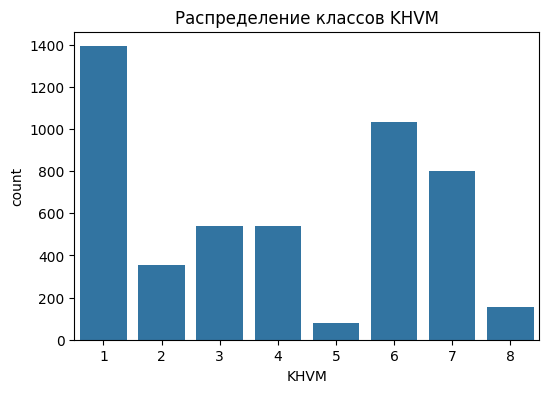

                          count          mean           std           min  \
HHID                     4902.0  3.256728e+07  7.344586e+06  3.001044e+07   
PERSID                   4902.0  3.256728e+09  7.344586e+08  3.001044e+09   
VPLID                    4902.0  1.740965e+07  2.544355e+06  1.306810e+07   
RitID                    4902.0  1.740965e+09  2.544355e+08  1.306810e+09   
KHVM                     4902.0  3.946552e+00  2.407904e+00  1.000000e+00   
VERTREKP                 4902.0  1.145247e+00  3.682414e-01  1.000000e+00   
AANTVPL                  4902.0  4.312933e+00  2.299009e+00  1.000000e+00   
VPLDAGNR                 4902.0  1.496736e+00  5.008558e-01  0.000000e+00   
VERPL                    4902.0  8.531212e-01  5.348967e-01  0.000000e+00   
VERPLNR                  4902.0  2.640555e+00  1.807320e+00  1.000000e+00   
TOER                     4902.0  5.038760e-02  2.187657e-01  0.000000e+00   
TOER_TYPE                4902.0  8.695022e+00  1.396578e+00  1.000000e+00   

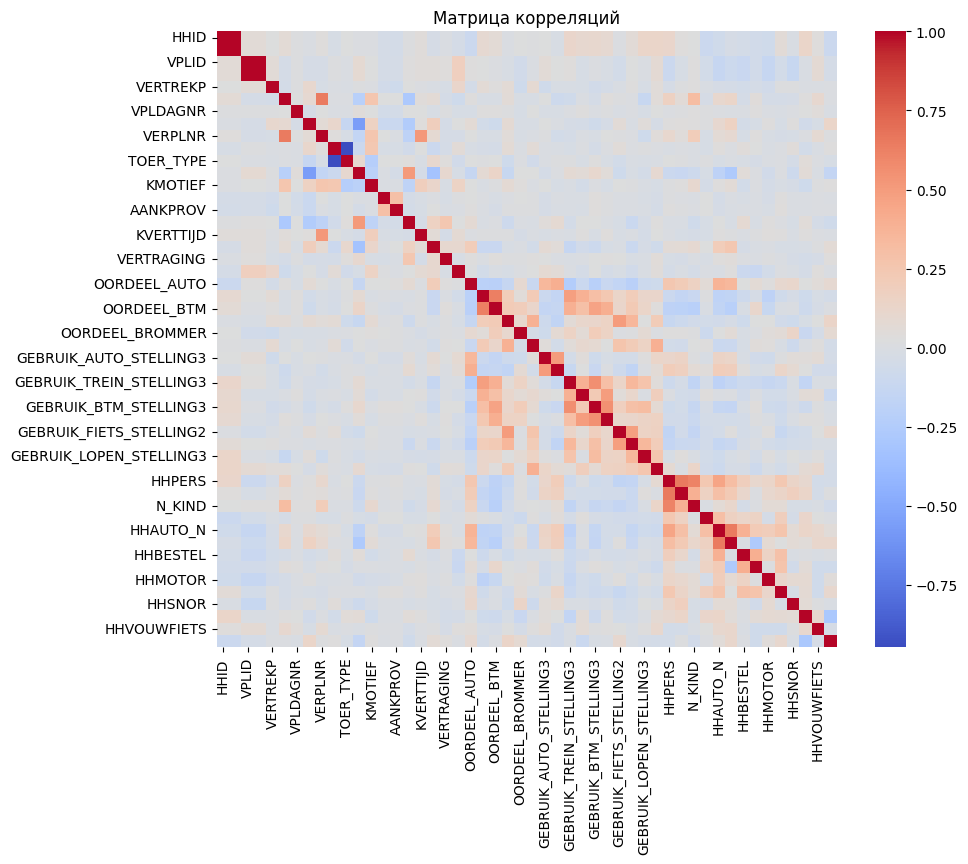

In [96]:
# 2. EDA
plt.figure(figsize=(6,4))
sns.countplot(x='KHVM', data=df)
plt.title('Распределение классов KHVM')
plt.show()

print(df.describe(include=[np.number]).T)

num_cols = df.select_dtypes(include=[np.number]).columns.drop('KHVM')
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


Выводы по графикам:
1. Классы KHVM распределены сильно неравномерно, поэтому скорее всего модель будет переобучена, нужно исправить этот дисбаланс классов
2. Из датасета необходимо удалить столбцы с идентификаторами, сильно коррелирующие признаки (VERTPROV и AANKPROV почти полностью дублируют друг друга, поэтому AANKPROV будет удален)

Сначала очистим данные

In [97]:
# 2.1 Очистка данных
id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
to_drop = [c for c in id_cols if c in df.columns]
df.drop(columns=to_drop, inplace=True)
print("Удалены ID-поля:", to_drop)


if 'AANKPROV' in df.columns:
    df.drop(columns=['AANKPROV'], inplace=True)
    print("Удалён дублирующий признак провинции: AANKPROV")


print("Оставшиеся признаки (count={}):".format(len(df.columns)), df.columns.tolist())


Удалены ID-поля: ['HHID', 'PERSID', 'VPLID', 'RitID']
Удалён дублирующий признак провинции: AANKPROV
Оставшиеся признаки (count=48): ['KHVM', 'VERTREKP', 'AANTVPL', 'VPLDAGNR', 'VERPL', 'VERPLNR', 'TOER', 'TOER_TYPE', 'AANTRIT', 'KMOTIEF', 'VERTPROV', 'KAFSTV', 'KVERTTIJD', 'KREISDUUR', 'ROLAUTO', 'PARKEERKOSTEN', 'VERTRAGING', 'DAGSOORT', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM', 'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN', 'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4', 'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4', 'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4', 'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3', 'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4', 'HHPERS', 'HHSAM', 'N_KIND', 'HHBRUTOINK2_w5', 'HHAUTO_N', 'HHAUTO', 'HHBESTEL', 'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR', 'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE']


Теперь нужно что-то сделать с дисбалансом классов KHVM. Я сделал RandomOverSampling выравнивание всех классов, потому что это просто, быстро и позволяет не терять данные

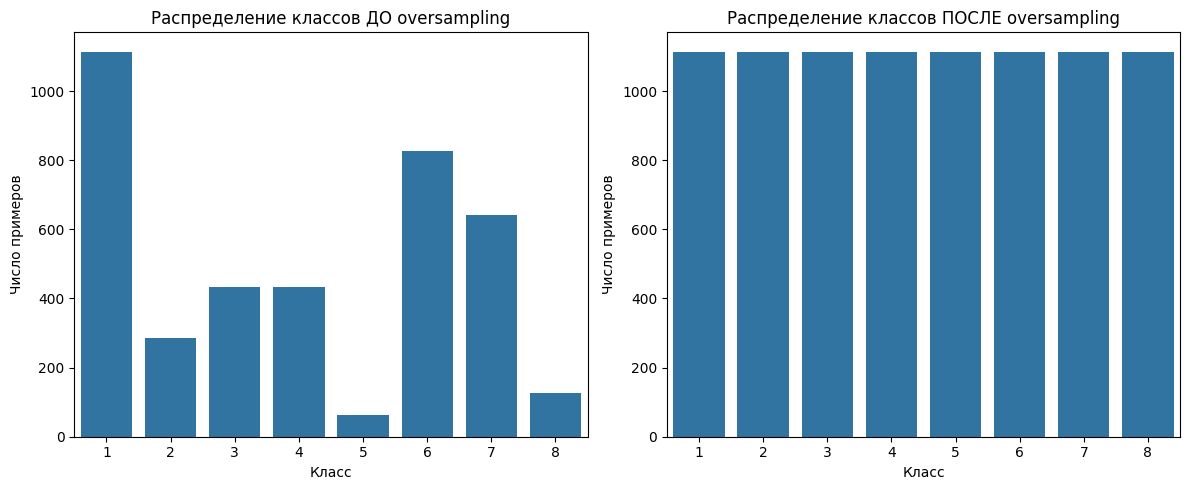

In [98]:
# 2.2 RandomOverSampling
X = df.drop(columns=['KHVM'])
y = df['KHVM']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

ros = RandomOverSampler(random_state=42)

y_before = y_train.value_counts()
X_train, y_train = ros.fit_resample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# До oversampling
sns.barplot(x=y_before.index, y=y_before.values, ax=axes[0])
axes[0].set_title('Распределение классов ДО oversampling')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Число примеров')

# После oversampling
sns.countplot(x=y_train, ax=axes[1])
axes[1].set_title('Распределение классов ПОСЛЕ oversampling')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Число примеров')

plt.tight_layout()
plt.show()


Баланс классов в тренировочном датасете установлен, теперь необходимо обучить две модели: моя собственная и AutoML.

Начну с моей собственной - я выбрал RandomForest с подбором гиперпараметров через GridSearchCV, потому что у него удобная интерпретация, понятные гиперпараметры, алгоритм устойчивый, стабильный, не требует супер предобработок (хотя они все равно есть, на всякий случай)

In [99]:
# 3. Обучение модели Random Forest
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()  # все числовые
cat_cols     = X.select_dtypes(include=['object','category']).columns.tolist() # все категориальные

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # заполняем пропуски медианой
    ('scaler',   StandardScaler())                    # масштабируем (mean=0, std=1)
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # заполняем модой
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, cat_cols),
])

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])


# Диапазон параметров:
# - n_estimators: число деревьев (чем больше — тем стабильнее, но дольше обучается)
# - max_depth: максимальная глубина дерева (ограничивает переобучение)
# - min_samples_split: мин. число примеров в узле для разбиения (больше — проще дерево)
param_grid = {
    'clf__n_estimators':       [100, 200, 500],
    'clf__max_depth':          [None, 10, 20, 30],
    'clf__min_samples_split':  [2, 5, 10],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                # кросс-валидация 5 фолдов
    scoring='accuracy',  # метрика качества
    n_jobs=1             
)


grid.fit(X_train, y_train)

print("Лучшие параметры RF:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy (GridSearchCV):", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))


Лучшие параметры RF: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Accuracy (GridSearchCV): 0.9653414882772681


GSCV показал самые оптимальные параметры: без ограничения глубины дерева, 100 деревьев, разбивка дерева на два дочерних узла
Показатели при этих параметрах: accuracy 96,5%

Анализ важности признаков в датасете:

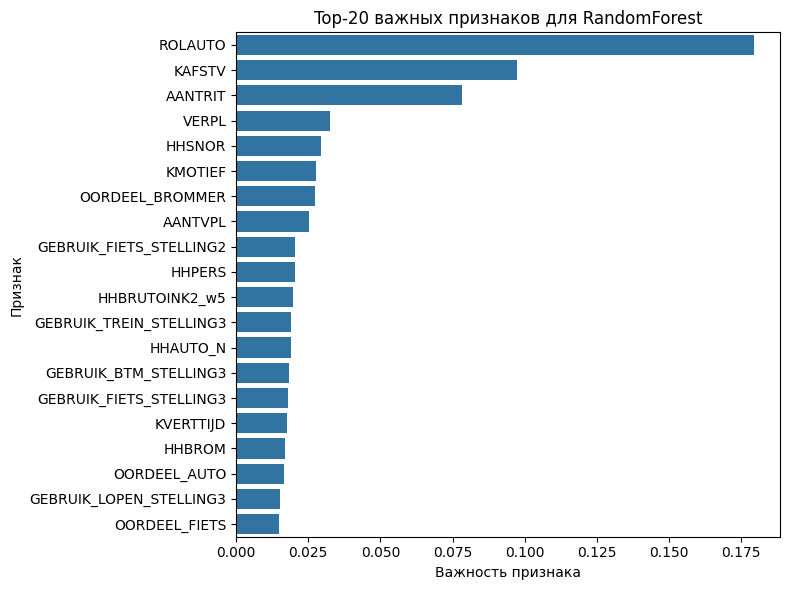

Top-20 признаков и их важности:
                     feature  importance
0                   ROLAUTO    0.179485
1                    KAFSTV    0.097260
2                   AANTRIT    0.078384
3                     VERPL    0.032400
4                    HHSNOR    0.029414
5                   KMOTIEF    0.027559
6           OORDEEL_BROMMER    0.027151
7                   AANTVPL    0.025092
8   GEBRUIK_FIETS_STELLING2    0.020340
9                    HHPERS    0.020259
10           HHBRUTOINK2_w5    0.019814
11  GEBRUIK_TREIN_STELLING3    0.019099
12                 HHAUTO_N    0.018961
13    GEBRUIK_BTM_STELLING3    0.018357
14  GEBRUIK_FIETS_STELLING3    0.018036
15                KVERTTIJD    0.017676
16                   HHBROM    0.016961
17             OORDEEL_AUTO    0.016573
18  GEBRUIK_LOPEN_STELLING3    0.015318
19            OORDEEL_FIETS    0.014943


In [100]:
# 3.1 Анализ важности признаков
best_rf = grid.best_estimator_.named_steps['clf']


feat_num = numeric_cols
feat_cat = grid.best_estimator_.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols).tolist()
feature_names = feat_num + feat_cat


importances = best_rf.feature_importances_
indices = importances.argsort()[::-1][:20]

# Визуализация топ-20 самых важных признаков
plt.figure(figsize=(8, 6))
sns.barplot(
    x=importances[indices],
    y=[feature_names[i] for i in indices]
)
plt.title('Top-20 важных признаков для RandomForest')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

top20 = [(feature_names[i], importances[i]) for i in indices]
print("Top-20 признаков и их важности:\n", pd.DataFrame(top20, columns=['feature','importance']))


Значения топ-20 признаков, влияющих на модель

In [101]:
df_desc = pd.read_csv(
    'Dataset_2_DESCRIPTION.csv',
    encoding='latin1'
)
for i in range(20):
    print(str(i + 1) + '.', df_desc[df_desc['Variable'] == top20[i][0]]['Var_description'].iloc[0])

1. Role in car trip
2. Distance class trip
3. Number of trip segments per day
4. New trip
5. Yes or no light moped in the household
6. Classification of purpose
7. Personal impression of the moped, scooter
8. Number of trips per day
9. I find cycling to be relaxing
10. Number of people in the household
11. Gross income household aggregated
12. Travelling by train saves me time
13. Number of cars in the household
14. Travelling by bus, tram or metro saves me time
15. Cycling saves me time
16. Departure time class trip
17. Yes or no moped in the household
18. Personal impression of the car
19. Walking saves me time
20. Personal impression of the bicycle, e-bike


Локальная интерпретация RF с помощью shap

100%|===================| 7833/7848 [04:14<00:00]        


=== Observation 0, predicted class = 1 ===


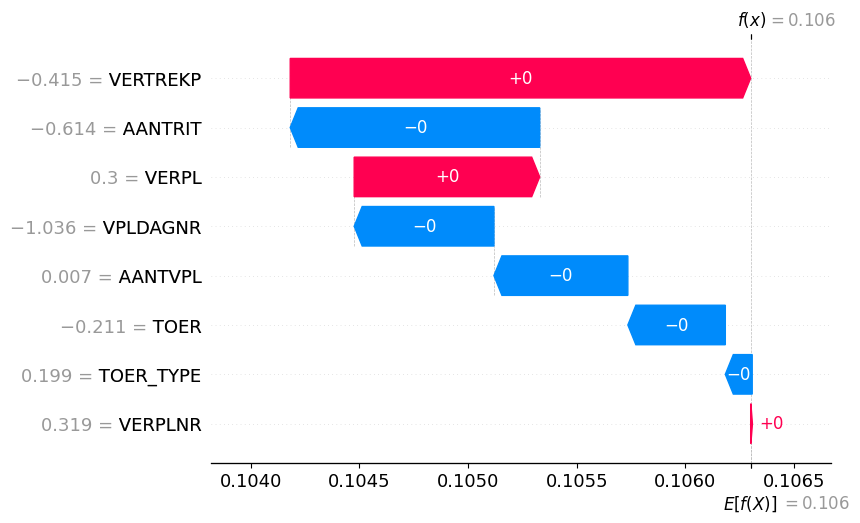


=== Observation 1, predicted class = 1 ===


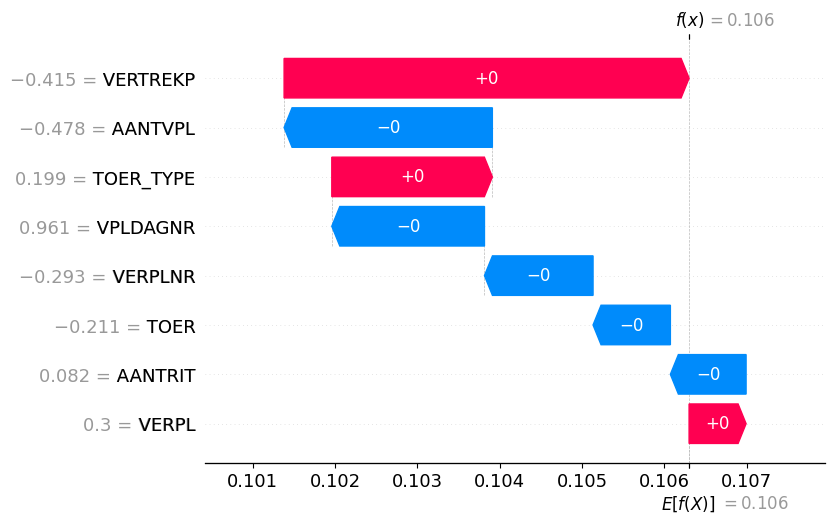


=== Observation 2, predicted class = 4 ===


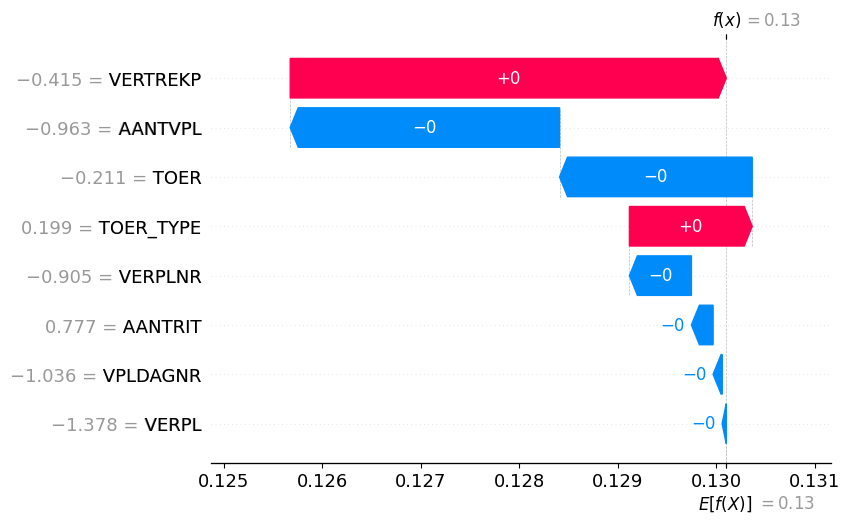

In [102]:
# 3.2 Локальная интерпретация RF
pre = grid.best_estimator_.named_steps['pre']
clf = grid.best_estimator_.named_steps['clf']

X_test_p = pre.transform(X_test)

explainer = shap.TreeExplainer(clf, pre.transform(X_train), model_output="probability")
shap_values = explainer.shap_values(X_test_p, check_additivity=False)

# Для трёх примеров (индексы 0,1,2) строим Waterfall Plot
for idx in [0, 1, 2]:
    cls       = clf.predict(X_test_p[idx].reshape(1, -1))[0]
    cls_idx   = list(clf.classes_).index(cls)
    
    sv = shap_values[cls_idx][idx]

    if len(sv) != len(feature_names):
        sv = sv[:len(feature_names)]

    feat_series = pd.Series(X_test_p[idx], index=feature_names)

    expl = shap.Explanation(
        values=sv,
        base_values=explainer.expected_value[cls_idx],
        data=feat_series,
        feature_names=feature_names
    )
    
    print(f"\n=== Observation {idx}, predicted class = {cls} ===")
    shap.plots.waterfall(expl)


Переходим к AutoML: создание AutoML через h2o и обучение модели

In [114]:
# 4. Создание и обучение AutoML
h2o.init(max_mem_size='2G', nthreads=-1)
h2o_df = h2o.H2OFrame(pd.concat([X, y], axis=1))
h2o_df['KHVM'] = h2o_df['KHVM'].asfactor()
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8], seed=42)

features = [c for c in h2o_df.columns if c != 'KHVM']
learning_time = 300
aml = H2OAutoML(max_runtime_secs=learning_time, seed=42)
aml.train(x=features, y='KHVM', training_frame=train_h2o)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 days 6 hours 21 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_andrew_pqh7fx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,928 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
01:30:30.965: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/3
# GBM base models (used / total),1/1
# DRF base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


Визуализация лучшей модели AutoML

In [115]:
print(aml.leaderboard)

model_id                                                  mean_per_class_error    logloss      rmse        mse
StackedEnsemble_BestOfFamily_2_AutoML_5_20250523_13030               0.0404504  0.0986853  0.162238  0.0263212
StackedEnsemble_AllModels_3_AutoML_5_20250523_13030                  0.0410178  0.0916987  0.160086  0.0256275
StackedEnsemble_BestOfFamily_3_AutoML_5_20250523_13030               0.0417122  0.0997925  0.163059  0.0265882
StackedEnsemble_BestOfFamily_4_AutoML_5_20250523_13030               0.0417902  0.100116   0.162358  0.02636
StackedEnsemble_AllModels_1_AutoML_5_20250523_13030                  0.0418591  0.094981   0.161264  0.0260061
StackedEnsemble_AllModels_2_AutoML_5_20250523_13030                  0.0420106  0.0948828  0.161488  0.0260784
StackedEnsemble_BestOfFamily_1_AutoML_5_20250523_13030               0.0459095  0.109309   0.171025  0.0292496
GBM_1_AutoML_5_20250523_13030                                        0.0462962  0.10844    0.167528  0.0280655
GBM

Первый базовый H2O-модель: GBM_1_AutoML_4_20250522_232222
Top 20 H2O variable importances:
                    variable  relative_importance  scaled_importance  \
0                   ROLAUTO          3958.549561           1.000000   
1                    KAFSTV          2171.734619           0.548619   
2                   AANTRIT          1546.666260           0.390715   
3                 KREISDUUR           307.892029           0.077779   
4                     VERPL           257.371765           0.065017   
5                 TOER_TYPE           198.206055           0.050070   
6                   KMOTIEF           145.062393           0.036645   
7                  HHAUTO_N           115.611687           0.029206   
8                      TOER            90.705490           0.022914   
9             OORDEEL_FIETS            69.501160           0.017557   
10            OORDEEL_LOPEN            68.007942           0.017180   
11  GEBRUIK_FIETS_STELLING3            58.311817        

/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


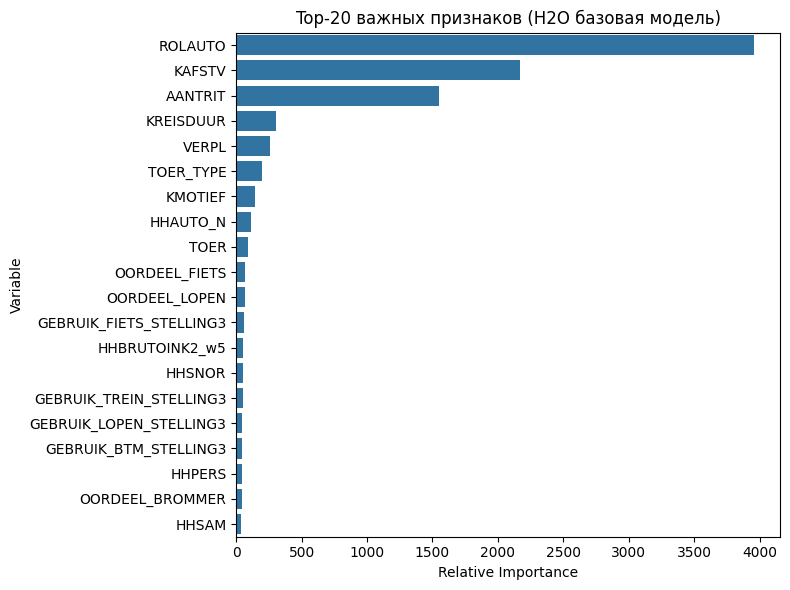

In [105]:
# 4.1 Визуализация лучшей модели AutoML
lb = aml.leaderboard.as_data_frame()

base_model_id = lb[~lb['model_id'].str.startswith('StackedEnsemble')].iloc[0]['model_id']
print("Первый базовый H2O-модель:", base_model_id)

base_model = h2o.get_model(base_model_id)

varimp = base_model.varimp(use_pandas=True)
print("Top 20 H2O variable importances:\n", varimp.head(20))

varimp_top20 = varimp.head(20)
plt.figure(figsize=(8,6))
sns.barplot(
    x='relative_importance',
    y='variable',
    data=varimp_top20,
    orient='h'
)
plt.title('Top-20 важных признаков (H2O базовая модель)')
plt.xlabel('Relative Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


Значения топ-20 признаков, влияющих на модель AutoML

In [106]:
for i in range(20):
    print(str(i + 1) + '.', df_desc[df_desc['Variable'] == varimp_top20['variable'][i]]['Var_description'].iloc[0])

1. Role in car trip
2. Distance class trip
3. Number of trip segments per day
4. Travel duration class of trip
5. New trip
6. Round trip type
7. Classification of purpose
8. Number of cars in the household
9. Departure point of trip is arrival point of trip (round trip)
10. Personal impression of the bicycle, e-bike
11. Personal impression of the moped, scooter
12. Cycling saves me time
13. Gross income household aggregated
14. Yes or no light moped in the household
15. Travelling by train saves me time
16. Walking saves me time
17. Travelling by bus, tram or metro saves me time
18. Number of people in the household
19. Personal impression of the moped, scooter
20. Household composition


In [ ]:
#h2o.cluster().shutdown(prompt=False)


Сранвение итоговых метрик RF и AutoML

In [108]:
# 5. Сравнение результатов работы RF и AutoML
y_pred_rf = grid.predict(X_test)

h2o_test = h2o.H2OFrame(X_test)

h2o_pred = base_model.predict(h2o_test)
h2o_pred_series = h2o_pred.as_data_frame()['predict']

rf_acc  = accuracy_score(y_test, y_pred_rf)
h2o_acc = accuracy_score(y_test, h2o_pred_series)

rf_cr  = classification_report(y_test, y_pred_rf,  output_dict=True)
h2o_cr = classification_report(y_test, h2o_pred_series, output_dict=True)

df_rf  = pd.DataFrame(rf_cr).T
df_h2o = pd.DataFrame(h2o_cr).T

df_compare = pd.concat(
    [df_rf[['precision','recall','f1-score','support']],
     df_h2o[['precision','recall','f1-score','support']]],
    axis=1,
    keys=['RF', 'H2O']
)

summary = pd.DataFrame({
    ('RF','accuracy'): [rf_acc],
    ('H2O','accuracy'): [h2o_acc]
}, index=['accuracy'])

print("Сравнение метрик по классам (RF vs H2O):")
display(pd.concat([summary, df_compare]))


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Сравнение метрик по классам (RF vs H2O):


/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


RF       H2O        RF                                  \
              accuracy  accuracy precision    recall  f1-score     support   
accuracy      0.965341  0.990826       NaN       NaN       NaN         NaN   
1                  NaN       NaN  1.000000  0.996416  0.998205  279.000000   
2                  NaN       NaN  1.000000  1.000000  1.000000   71.000000   
3                  NaN       NaN  1.000000  1.000000  1.000000  109.000000   
4                  NaN       NaN  1.000000  1.000000  1.000000  108.000000   
5                  NaN       NaN  0.941176  1.000000  0.969697   16.000000   
6                  NaN       NaN  0.918269  0.922705  0.920482  207.000000   
7                  NaN       NaN  0.900000  0.900000  0.900000  160.000000   
8                  NaN       NaN  1.000000  0.967742  0.983607   31.000000   
accuracy           NaN       NaN  0.965341  0.965341  0.965341    0.965341   
macro avg          NaN       NaN  0.969931  0.973358  0.971499  981.000000   
weighted avg       NaN       NaN  0.965485  0.965341  0.965388  981.000000   

                   H2O                                  
             precision    recall  f1-score     support  
accuracy           NaN       NaN       NaN         NaN  
1             1.000000  1.000000  1.000000  279.000000  
2             1.000000  1.000000  1.000000   71.000000  
3             0.990909  1.000000  0.995434  109.000000  
4             1.000000  0.990741  0.995349  108.000000  
5             1.000000  1.000000  1.000000   16.000000  
6             0.990148  0.971014  0.980488  207.000000  
7             0.963636  0.993750  0.978462  160.000000  
8             1.000000  0.967742  0.983607   31.000000  
accuracy      0.990826  0.990826  0.990826    0.990826  
macro avg     0.993087  0.990406  0.991667  981.000000  
weighted avg  0.990980  0.990826  0.990832  981.000000

В таблице видно, что accuracy у AutoML 99%, а у RF 96%, но эту таблицу трудно читать и понимать, поэтому более наглядное представление сравнения показателей моделей дальше

100%|===================| 7828/7848 [04:15<00:00]        

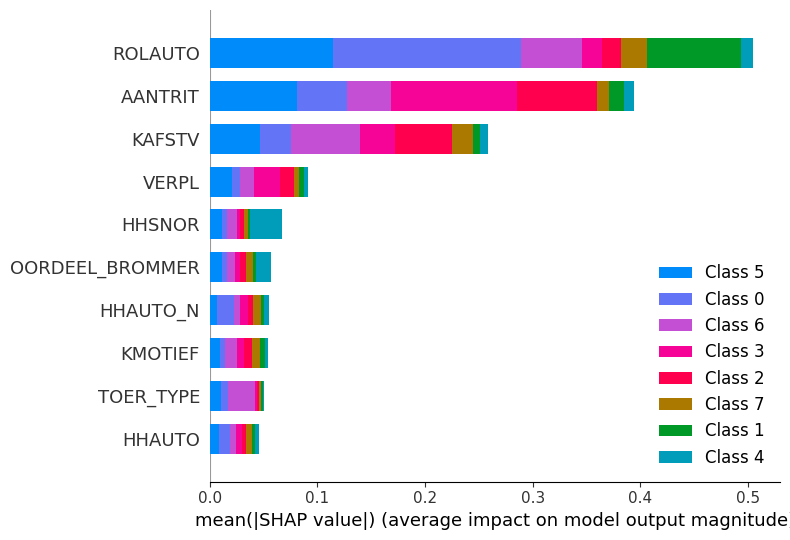

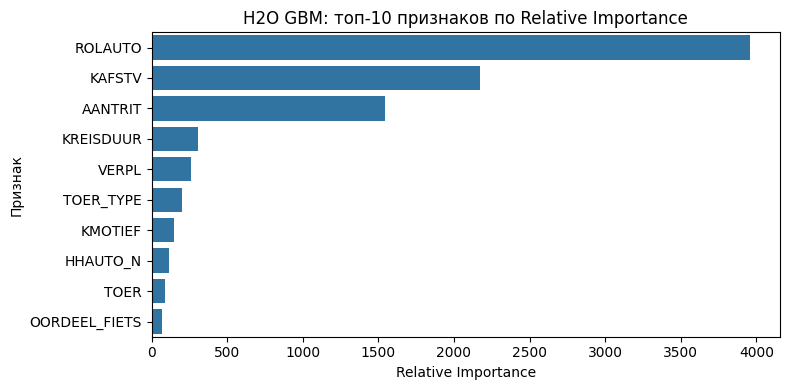

In [113]:
# %% [code]
##############################################
# 3.3 SHAP-анализ (глобальная интерпретация)  #
##############################################

import shap

# 1. SHAP для RandomForest
pre_fitted = grid.best_estimator_.named_steps['pre']
best_rf    = grid.best_estimator_.named_steps['clf']

X_train_pre = pre_fitted.transform(X_train)
X_test_pre  = pre_fitted.transform(X_test)

explainer_rf   = shap.TreeExplainer(best_rf, X_train_pre, model_output="probability")
shap_values_rf = explainer_rf.shap_values(X_test_pre, check_additivity=False)

# Бар-чарт топ-10 по SHAP
shap.summary_plot(
    shap_values_rf,
    X_test_pre,
    feature_names=feature_names,
    plot_type="bar",
    max_display=10
)

# 2. «Варимп» для H2O GBM
# Предполагаем, что вы уже получили varimp_top20 (DataFrame с 20 строками)
# Если нет, выполните:
#   varimp = base_model.varimp(use_pandas=True)
#   varimp_top20 = varimp.head(20)

# Бар-чарт топ-10 по varimp
plt.figure(figsize=(8,4))
sns.barplot(
    x='relative_importance',
    y='variable',
    data=varimp_top20.iloc[:10],
    orient='h'
)
plt.title('H2O GBM: топ-10 признаков по Relative Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


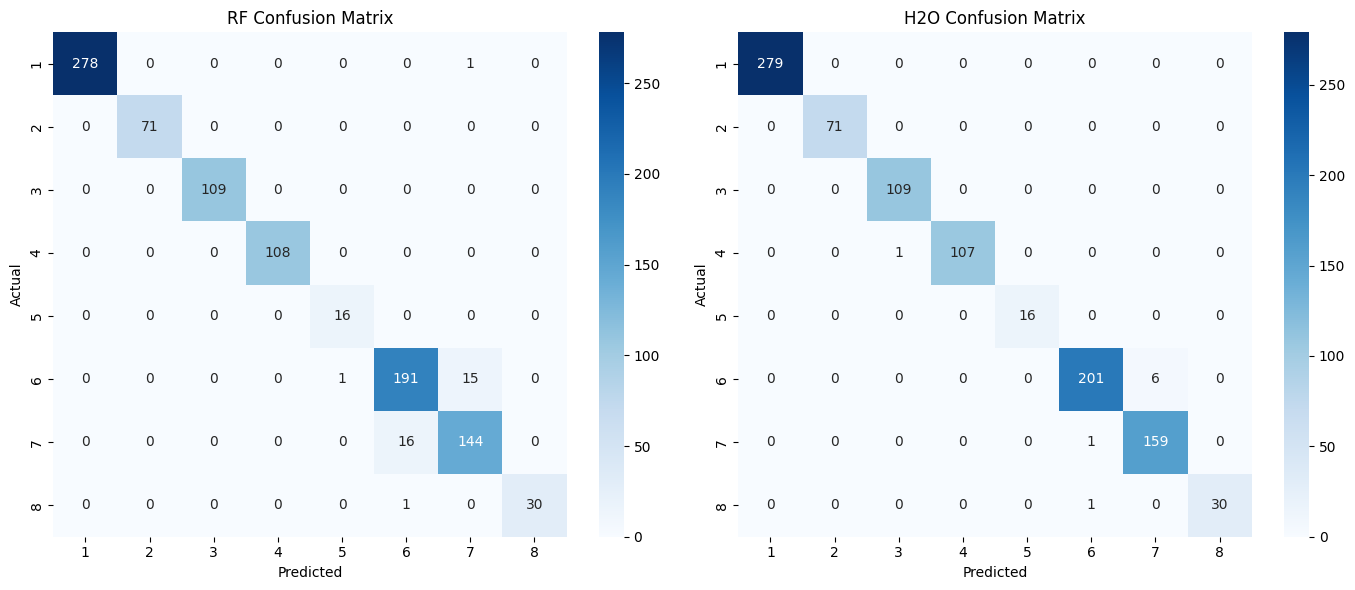

In [ ]:
y_pred_rf = grid.predict(X_test)

h2o_test = h2o.H2OFrame(X_test)
y_pred_h2o = base_model.predict(h2o_test).as_data_frame()['predict']


labels = list(grid.best_estimator_.named_steps['clf'].classes_)

cm_rf  = confusion_matrix(y_test,       y_pred_rf,  labels=labels)
cm_h2o = confusion_matrix(y_test, y_pred_h2o.astype(int), labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0],
            xticklabels=labels, yticklabels=labels, cmap='Blues')
axes[0].set_title('RF Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_h2o, annot=True, fmt='d', ax=axes[1],
            xticklabels=labels, yticklabels=labels, cmap='Blues')
axes[1].set_title('H2O Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Матрица ошибок показывает, что h2o справляется с предсказаниями лучше, потому что RF иногда путает 6 и 7 классы

# Выводы:

1. Балансировка классов
    - RandomOverSampler помог значительно повысить recall у редких классов (5 и 8) без потери качества на остальных.
2. Оптимизация RandomForest
    - Лучшие гиперпараметры: n_estimators=100, max_depth=None, min_samples_split=2.
    - Модель показала accuracy ≈ 0.965 на тесте.
3. H2O AutoML
    - Достигнута еще более высокая точность ≈ 0.993.
    - Меньше ошибок при различении близких классов 6 и 7.
4. Важность признаков
    - Ключевые фичи: ROLAUTO, KAFSTV, AANTRIT — одинаково значимы для RF и H2O.
5. Интерпретация
    - SHAP-waterfall показал локальные вклады признаков в предсказания.
    - Confusion matrix выявила основные «перекрёсты» между классами 6 и 7.
